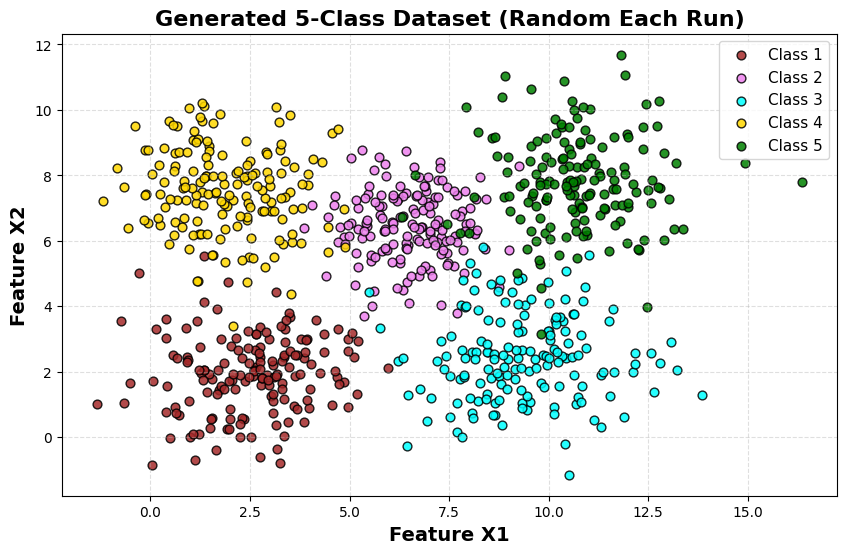

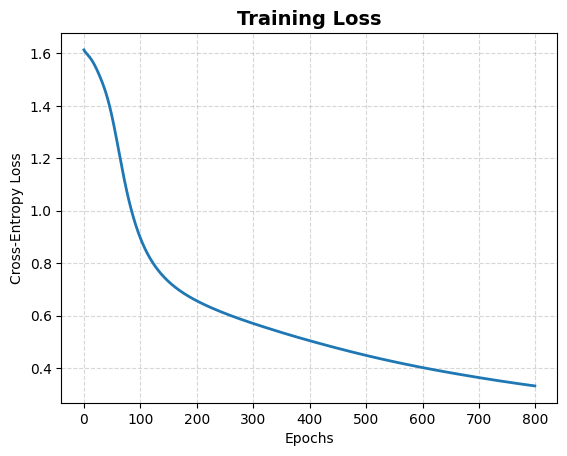

Accuracy: 0.8958333333333334

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        48
           1       0.90      0.73      0.80        48
           2       0.94      0.92      0.93        48
           3       0.92      0.98      0.95        48
           4       0.75      0.90      0.82        48

    accuracy                           0.90       240
   macro avg       0.90      0.90      0.90       240
weighted avg       0.90      0.90      0.90       240



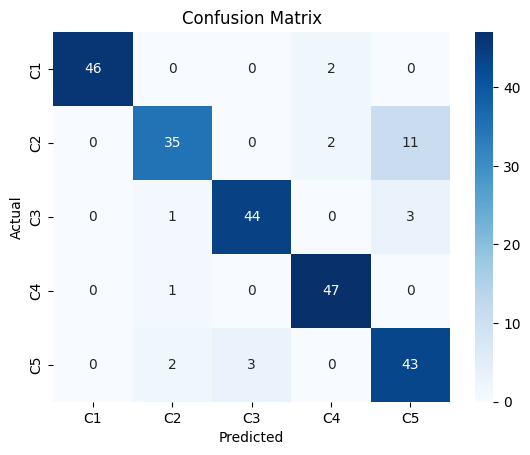

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Function to generate a 5-class dataset (random each run)
def make_dataset(points_per_class=160):
    rng = np.random.default_rng()  # No fixed seed
    clusters = [
        rng.normal(loc=[2.5, 2], scale=1.3, size=(points_per_class, 2)),
        rng.normal(loc=[6.5, 6.5], scale=1.1, size=(points_per_class, 2)),
        rng.normal(loc=[9.5, 2.5], scale=1.4, size=(points_per_class, 2)),
        rng.normal(loc=[2, 7.5], scale=1.2, size=(points_per_class, 2)),
        rng.normal(loc=[10.5, 7.8], scale=1.3, size=(points_per_class, 2))
    ]
    X = np.concatenate(clusters, axis=0)
    y = np.repeat(np.arange(len(clusters)), points_per_class)
    return X, y

# Generate dataset
X, y = make_dataset()

# Visualize Data with random colors
plt.figure(figsize=(10, 6))
rng = np.random.default_rng()
colors = rng.choice([
    "red", "green", "blue", "gold", "violet", "orange", "cyan", "magenta", "brown", "pink"
], size=len(np.unique(y)), replace=False)

for cid in np.unique(y):
    plt.scatter(X[y == cid, 0], X[y == cid, 1],
                label=f"Class {cid+1}",
                edgecolor="black", s=40, alpha=0.85, c=colors[cid])
plt.title("Generated 5-Class Dataset (Random Each Run)", fontsize=16, weight="bold")
plt.xlabel("Feature X1", fontsize=14, weight="bold")
plt.ylabel("Feature X2", fontsize=14, weight="bold")
plt.legend(frameon=True, fontsize=11)
plt.grid(True, alpha=0.4, linestyle="--")
plt.show()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# One-Hot Encode Labels
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Simple Neural Network
class SimpleNN:
    def __init__(self, input_dim, hidden_units, output_dim, lr=0.01):
        rng = np.random.default_rng()  # No seed
        self.W1 = rng.standard_normal((input_dim, hidden_units)) * 0.05
        self.b1 = np.zeros((1, hidden_units))
        self.W2 = rng.standard_normal((hidden_units, output_dim)) * 0.05
        self.b2 = np.zeros((1, output_dim))
        self.lr = lr

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_deriv(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def compute_loss(self, Y_hat, Y):
        m = Y.shape[0]
        log_probs = -np.log(Y_hat[range(m), np.argmax(Y, axis=1)])
        return np.mean(log_probs)

    def backward(self, X, Y):
        m = X.shape[0]
        dZ2 = self.A2 - Y
        dW2 = (self.A1.T @ dZ2) / m
        db2 = np.mean(dZ2, axis=0, keepdims=True)
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_deriv(self.Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.mean(dZ1, axis=0, keepdims=True)
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def fit(self, X, Y, epochs=800):
        history = []
        for _ in range(epochs):
            Y_hat = self.forward(X)
            loss = self.compute_loss(Y_hat, Y)
            self.backward(X, Y)
            history.append(loss)
        return history

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

# Train NN
model = SimpleNN(input_dim=2, hidden_units=12, output_dim=5, lr=0.04)
losses = model.fit(X_train, y_train_encoded, epochs=800)

# Plot Loss
plt.plot(losses, linewidth=2)
plt.title("Training Loss", fontsize=14, weight="bold")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"C{i+1}" for i in range(5)],
            yticklabels=[f"C{i+1}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

